In [1]:
# notebook last tested with abtem version 1.0.0beta32
%matplotlib inline

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data
import matplotlib.pyplot as plt
from scipy import constants
from abtem import *
import numpy as np

/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current version: 1.0.0beta32


# HRTEM simulation of nanoparticle

We build a nanoparticle with around 2000 atoms as a Wulff construction. We add vacuum to all sides of the model and the nanoparticle is rotated to align with the <110> zone axis.

Number of atoms: 16727


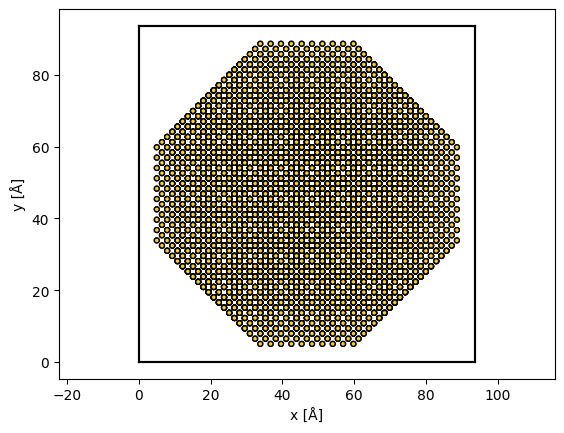

In [2]:
z1 = 45
x  = 45
z2 = 45

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets

esurf = [1.0, 1.1, 0.9] # Relative surface energies

size = 16000 # Target number of atoms

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.rotate(z1, 'z', center='cop')
atoms.rotate(x, 'z', center='cop')
atoms.rotate(z2, 'z', center='cop')

atoms.center(vacuum=5.)

atoms.center(vacuum=2., axis=2)

show_atoms(atoms)

print("Number of atoms:", len(atoms))

Get a reasonable sampling (0.05 Å)

In [3]:
gridpoints = int(max(atoms.cell[0,0], atoms.cell[1,1]) / 0.05)
print("Grid points:", gridpoints)
# Probably wise to round to a power of two
#gridpoints = 2048
#gridpoints = 3072
gridpoints = 4096
#gridpoints = 6144


Grid points: 1873


We create the electrostatic potential. In this example, we use the infinite projection scheme to allow the notebook to run with low computational resources. The sampling used here is also a bit rough.

To simulate temperature effects set ``phonons`` to True below.  That enables *the frozen phonon method*, at a cost of a factor 30 in computer time.

The average square displacement of the atoms is calculated from the Debye temperature of the material (here gold) and the actual temperature, see: E. M. Mannebach, et al.  Nano Letters 15 (2015) 6889, suppl. online info.

$$
\left<u^2\right> = {3 \hbar^2 \over 2 m k_B \theta_D} \cdot \left(\frac14 + {T
      \over \theta_D}\right)
$$

We create the incoming plane wave and start the multislice simulation.

In [4]:
angle = 2*4.5e-3
defocus = 40/np.sin(angle)

mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
TD = 165  # Kittel
T = 300
U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
             * (1/4 + T / TD))
sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
print(sigmas)
num_configs = 10 # number of frozen phonon configurations

frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)

for i,config in enumerate(frozen_phonons):

    potential = Potential(config, 
                          gpts=gridpoints, 
                          slice_thickness=0.5, 
                          device='gpu',
                          #storage='cpu',
                          precalculate=False,
                          parametrization='kirkland', 
                          projection='infinite')

    probe = Probe(sampling=potential.sampling,
        device='gpu',
        semiangle_cutoff=1000*angle,
        extent=potential.extent,
        defocus=defocus,
        energy=30e3 # acceleration voltage in eVhttp://localhost:8080/notebooks/Kikuchi.ipynb#
    )
    positions = (45, 45)



#waves = wave.multislice(positions, potential)
#exit_wave = probe.multislice(positions, potential)
        
    %time exit_wave = probe.multislice(positions, potential)
    
    cbed_diffraction_pattern = exit_wave.diffraction_pattern(block_zeroth_order=0)
    
    if (i==0):
        summedImage = cbed_diffraction_pattern.array
    else:
        summedImage += cbed_diffraction_pattern.array
        
    
    #else:
    #    np.append(FinalExitWave.array, exit_wave.array, axis = 2)
    #print(FinalExitWave.array.shape)

#%time exit_wave = wave.multislice(potential)
cbed_diffraction_pattern.array[:] = summedImage/num_configs
exit_wave.array.shape

{'Au': 0.0680474303682167}


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 33.68it/s]


CPU times: user 2.06 s, sys: 3.05 s, total: 5.12 s
Wall time: 6.42 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.23it/s]


CPU times: user 1.48 s, sys: 1.93 s, total: 3.41 s
Wall time: 3.42 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 35.55it/s]


CPU times: user 1.92 s, sys: 2.71 s, total: 4.63 s
Wall time: 4.64 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 35.01it/s]


CPU times: user 1.94 s, sys: 2.77 s, total: 4.71 s
Wall time: 4.71 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 40.69it/s]


CPU times: user 1.75 s, sys: 2.31 s, total: 4.06 s
Wall time: 4.05 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 39.05it/s]


CPU times: user 1.78 s, sys: 2.43 s, total: 4.21 s
Wall time: 4.21 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 34.15it/s]


CPU times: user 2.08 s, sys: 2.75 s, total: 4.83 s
Wall time: 4.83 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 33.63it/s]


CPU times: user 2.12 s, sys: 2.79 s, total: 4.91 s
Wall time: 4.9 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 39.39it/s]


CPU times: user 1.85 s, sys: 2.32 s, total: 4.17 s
Wall time: 4.18 s


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 164/164 [00:05<00:00, 31.29it/s]


CPU times: user 2.36 s, sys: 2.91 s, total: 5.27 s
Wall time: 5.27 s


(4096, 4096)

We can get the complex exit wave function as an array. Note, when temperature effects are included, we get out a stack of exit waves by default, one for each frozen phonon configuration.

In [5]:
print(exit_wave)

In [6]:
energy = probe.energy
del probe

Hack to move data back to CPU

In [7]:
if True:
    exit_wave._array = exit_wave._array.get()
    exit_wave._device = 'cpu'

We show the intensity of the first exit wave and the intensity of the thermal ensemble. To get get the intensity of the thermal ensemble, we take the mean across the ensemble dimension after calculating the intensity.

We can get the diffraction pattern up to a chosen scattering angle, we can block the zero order spot and display it on a power scale.

In [8]:
# from scipy.ndimage import gaussian_filter
# cbed_diffraction_pattern.array[:] = gaussian_filter(cbed_diffraction_pattern.array, sigma=1)

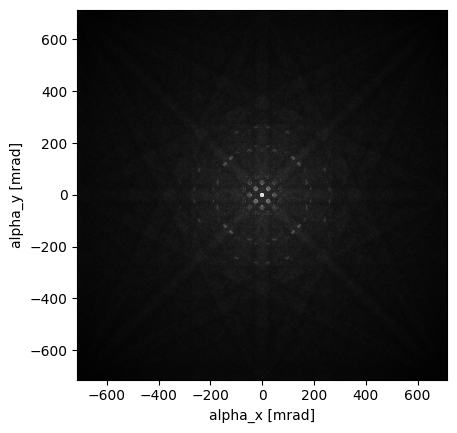

In [9]:
ax, im = cbed_diffraction_pattern.show(power = 0.25)
# ax.set_xlim([-240,240])
# ax.set_ylim([-240,240]);



In [10]:
cbed_diffraction_pattern.array.shape

(1917, 1917)

(<AxesSubplot: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f90eaa53460>)

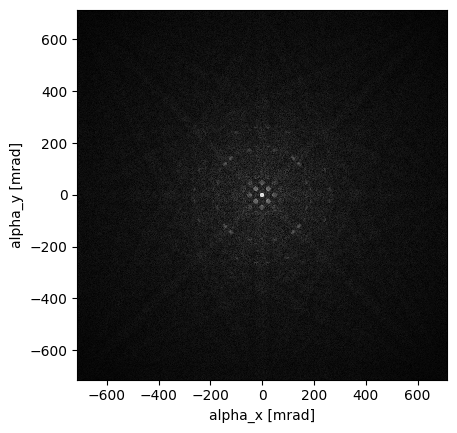

In [11]:
diff = exit_wave.diffraction_pattern(block_zeroth_order=0)
diff.show(power=.25)

In [12]:
angle*1000


9.0

In [13]:
type(diff)

abtem.measure.Measurement